In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [31]:
# Read dataset
with open('Datasets/JayChouLyrics/jaychou_lyrics.txt', 'r', encoding='utf-8') as lyrics:
    data = lyrics.read()

data = data[:10000]
data = data.replace('\n', ' ')
chars = sorted(list(set(data)))
vocab_size = len(chars)

stoi = {s:i for i, s in enumerate(chars)}
itos = {i:s for s, i in stoi.items()}

dataset = [stoi[s] for s in data]
print(''.join(s for s in data[:20]))
print(list(stoi[s] for s in data[:20]))
print(dataset[:20])

想要有直升机 想要和你飞到宇宙去 想要和
[403, 862, 506, 696, 149, 513, 0, 403, 862, 201, 84, 1000, 128, 286, 290, 161, 0, 403, 862, 201]
[403, 862, 506, 696, 149, 513, 0, 403, 862, 201, 84, 1000, 128, 286, 290, 161, 0, 403, 862, 201]


In [32]:
# Sample
import random

# Random sampling from datasets
def randomSample(data, batch_size, num_steps):
    num_sample = (len(data) - num_steps) // batch_size * batch_size
    idx_sample = list(range(num_sample))
    random.shuffle(idx_sample)
    epoch_size = num_sample // batch_size
    
    # create an iter
    for i in range(epoch_size):
        idx = i * batch_size
        batch_idx = idx_sample[idx : idx+batch_size]
        X = [data[n : n+num_steps] for n in batch_idx]
        y = [data[n+1 : n+num_steps+1] for n in batch_idx]
        yield torch.tensor(X), torch.tensor(y)

# Sequential sampling
def sequentialSample(data, batch_size, num_steps):
    num_sample = (len(data) - num_steps) // batch_size * batch_size
    idx_sample = list(range(num_sample))
    epoch_size = num_sample // batch_size
    
    # create an iter
    for i in range(epoch_size):
        idx = i * batch_size
        batch_idx = idx_sample[idx : idx+batch_size]
        X = [data[n : n+num_steps] for n in batch_idx]
        y = [data[n+1 : n+num_steps+1] for n in batch_idx]
        yield torch.tensor(X), torch.tensor(y)

In [33]:
data_iter = randomSample(dataset, 32, 35)
for X, y in data_iter:
    print(X.shape)

torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([32, 35])
torch.Size([3

In [34]:
a = randomSample([1,2,3,4,5,6,7,8], 2, 5)
for X, y in a:
    print(X)
    print(y)

a = sequentialSample([1,2,3,4,5,6,7,8], 2, 5)
for X, y in a:
    print(X)
    print(y)

tensor([[2, 3, 4, 5, 6],
        [1, 2, 3, 4, 5]])
tensor([[3, 4, 5, 6, 7],
        [2, 3, 4, 5, 6]])
tensor([[1, 2, 3, 4, 5],
        [2, 3, 4, 5, 6]])
tensor([[2, 3, 4, 5, 6],
        [3, 4, 5, 6, 7]])


# Rnn with random sampling

In [41]:
# Build rnn (random sampling)
# We have saved the parameters in './Parameters/rnnRandomSampling.pt' , use W_xh, W_hh, b_h, W_hq, b_q = torch.load('./Parameters/rnnRandomSampling.pt') to get them
torch.cuda.empty_cache()
torch.manual_seed(42)
random.seed(42) # make sure data_iter do not change

num_hidden = 256    # neurons in hidden layer
num_epochs, num_steps, batch_size, lr, clipping_theta = 200, 35, 32, 1, 1
device = "cuda" if torch.cuda.is_available() else "cpu"
loss = nn.CrossEntropyLoss(reduction='sum')


# Parameters in the net
W_xh = torch.randn([vocab_size, num_hidden], dtype=torch.float32, requires_grad=True, device=device)
W_hh = torch.randn([num_hidden, num_hidden], dtype=torch.float32, requires_grad=True, device=device)
# X(batch_size, vocab_size) @ Wxh(vocab_size, num_hidden) + H(batch_size, num_hidden) @ Whh(num_hidden, num_hidden)
# Equal to [X, H] @ [Wxh ; Whh], so we only need 1 bias
b_h = torch.randn([1, num_hidden], dtype=torch.float32, requires_grad=True, device=device)  

W_hq = torch.randn([num_hidden, vocab_size], dtype=torch.float32, requires_grad=True, device=device)
b_q = torch.randn([1, vocab_size], dtype=torch.float32, requires_grad=True, device=device)

parameters = [W_xh, W_hh, b_h, W_hq, b_q]
for p in parameters:
    p.data *= 0.01

# stats
times = 0
lossi = []
for epoch in range(num_epochs):
    data_iter = randomSample(dataset, batch_size, num_steps)
    
    for X, y in data_iter:
        train_X = F.one_hot(X, num_classes=vocab_size)  # one hot
        train_X = train_X.to(dtype=torch.float32, device=device) # (batch_size, num_steps, vocab_size)
        train_y = y.to(dtype=torch.long, device=device)  # (batch_size, num_steps)
        
        train_X = torch.stack([train_X[:, i, :] for i in range(train_X.shape[1])], dim=0) # (num_steps, batch_size, vocab_size)
        train_y = torch.stack([train_y[:, i] for i in range(train_y.shape[1])], dim=0)  # (num_steps, batch_size)
        
        # Forward pass
        H = torch.randn([batch_size, num_hidden], dtype=torch.float32, device=device)   # if is random sampling, we should update H before forward pass
        l = 0.0
        for step in range(train_X.shape[0]):
            H = torch.tanh(torch.matmul(train_X[step, :, :], W_xh) + torch.matmul(H, W_hh) + b_h)   # (batch_size, num_hidden) + (batch_size, num_hidden) + (1, num_hidden)
            output = torch.matmul(H, W_hq) + b_q    # (batch_size, vocab_size)  
            l += loss(output, train_y[step])
            
        l /= batch_size * num_steps
        
        # Backward pass
        for p in parameters:
            p.grad = None
        l.backward()
        
        # grad clipping
        with torch.no_grad():
            norm = torch.tensor(0.0, device=device)
            for p in parameters:
                norm += (p.grad.data ** 2).sum()        # .data means will not be watched by cag
            norm = norm.sqrt().item()
            if norm > clipping_theta:
                for p in parameters:
                    p.grad.data *= (clipping_theta / norm)

        for p in parameters:
            p.data += -lr * p.grad
        # Track stats
        lossi.append(l.item())
        if times % 100 == 0:
            print(f'time {times:7d} loss {l.item() :10f}')
            print(norm)

        times += 1        

time       0 loss   6.933767
0.1730150580406189
time     100 loss   5.723488
0.7506710290908813
time     200 loss   5.441651
0.2633466124534607
time     300 loss   5.418505
0.20400436222553253
time     400 loss   5.383307
0.4353576600551605
time     500 loss   4.797831
0.5182431936264038
time     600 loss   4.849635
0.562589168548584
time     700 loss   4.557041
0.6353398561477661
time     800 loss   4.472588
0.59026700258255
time     900 loss   4.164139
0.9017006158828735
time    1000 loss   3.701298
0.8845627307891846
time    1100 loss   3.417558
0.8665930032730103
time    1200 loss   3.554340
1.0104697942733765
time    1300 loss   3.406154
1.279147982597351
time    1400 loss   2.841587
0.963530421257019
time    1500 loss   2.997870
1.0666285753250122
time    1600 loss   2.307973
1.2648849487304688
time    1700 loss   2.654110
1.2626497745513916
time    1800 loss   2.533230
1.3385748863220215
time    1900 loss   1.985910
1.1185470819473267
time    2000 loss   2.021161
1.1261138916015

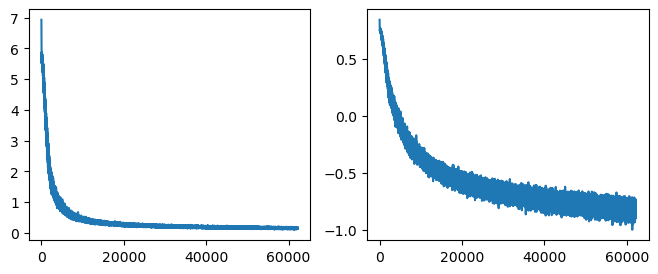

In [43]:
plt.subplots(1, 2, figsize=(8, 3))
plt.subplot(1,2,1); plt.plot(lossi)
lossi10 = [math.log10(i) for i in lossi]
plt.subplot(1,2,2);plt.plot(lossi10)

In [44]:
# Predict
torch.manual_seed(42)
word = "分开"
word2i = [stoi[s] for s in word]
length = 50     # impending words to corresponding length

words = []
H = torch.randn([1, num_hidden], dtype=torch.float32, device=device)
with torch.no_grad():
    for i in range(length):
        inputx = torch.tensor(word2i[i]) if i < len(word2i) else torch.tensor(words[-1])
        X = F.one_hot(inputx, num_classes=vocab_size).view(1, vocab_size)
        X = X.to(dtype=torch.float32, device=device)
        H = torch.tanh(torch.matmul(X, W_xh) + torch.matmul(H, W_hh) + b_h)   # (batch_size, num_hidden) + (batch_size, num_hidden) + (1, num_hidden)
        output = torch.matmul(H, W_hq) + b_q    # (batch_size, vocab_size)   
        probs = F.softmax(output, dim=1)
        y = probs.argmax(dim=1).item()
        if i < len(word2i):
            words.append(word2i[i])
        else:
            words.append(y)

print(''.join(itos[i] for i in words))

分开我 相思寄红豆 相思寄红豆无能为力的在人海中漂泊心伤透 娘子她人在江南等我 泪不休 语沉默 娘子


In [45]:
print(f'perplexity {math.exp(l.item())}')

perplexity 1.180812403675303


In [ ]:
# this is why we can't simply use .view to exchange dimensions
test = torch.tensor([[1, 2, 3, 4, 5, 6], [7, 8, 9, 10, 11, 12]])
print(test)
print('---')
print(torch.stack([test[:, i] for i in range(test.shape[1])], dim=0))
print('---')
print(test.view(test.shape[1], test.shape[0]))

# Rnn with consecutive sampling

In [46]:
# Build rnn (sequential sampling)
# We have saved the parameters in './Parameters/rnnSequentialSampling.pt' , use W_xh, W_hh, b_h, W_hq, b_q = torch.load('./Parameters/rnnRandomSampling.pt') to get them
torch.cuda.empty_cache()
torch.manual_seed(42)
random.seed(42) # make sure data_iter do not change

num_hidden = 256    # neurons in hidden layer
num_epochs, num_steps, batch_size, lr, clipping_theta = 200, 35, 32, 1, 1
device = "cuda" if torch.cuda.is_available() else "cpu"
loss = nn.CrossEntropyLoss(reduction='sum')


# Parameters in the net
W_xh = torch.randn([vocab_size, num_hidden], dtype=torch.float32, requires_grad=True, device=device)
W_hh = torch.randn([num_hidden, num_hidden], dtype=torch.float32, requires_grad=True, device=device)
# X(batch_size, vocab_size) @ Wxh(vocab_size, num_hidden) + H(batch_size, num_hidden) @ Whh(num_hidden, num_hidden)
# Equal to [X, H] @ [Wxh ; Whh], so we only need 1 bias
b_h = torch.randn([1, num_hidden], dtype=torch.float32, requires_grad=True, device=device)  

W_hq = torch.randn([num_hidden, vocab_size], dtype=torch.float32, requires_grad=True, device=device)
b_q = torch.randn([1, vocab_size], dtype=torch.float32, requires_grad=True, device=device)

parameters = [W_xh, W_hh, b_h, W_hq, b_q]
for p in parameters:
    p.data *= 0.01

# stats
times = 0
lossi = []
for epoch in range(num_epochs):
    data_iter = randomSample(dataset, batch_size, num_steps)
    H = torch.randn([batch_size, num_hidden], dtype=torch.float32, device=device)   # update H before a epoch

    for X, y in data_iter:
        H.detach_() # detach information of former computation from cag
        
        train_X = F.one_hot(X, num_classes=vocab_size)  # one hot
        train_X = train_X.to(dtype=torch.float32, device=device) # (batch_size, num_steps, vocab_size)
        train_y = y.to(dtype=torch.long, device=device)  # (batch_size, num_steps)
        
        train_X = torch.stack([train_X[:, i, :] for i in range(train_X.shape[1])], dim=0) # (num_steps, batch_size, vocab_size)
        train_y = torch.stack([train_y[:, i] for i in range(train_y.shape[1])], dim=0)  # (num_steps, batch_size)
        
        # Forward pass
        # if is random sampling, we should update H before forward pass
        l = 0.0
        for step in range(train_X.shape[0]):
            H = torch.tanh(torch.matmul(train_X[step, :, :], W_xh) + torch.matmul(H, W_hh) + b_h)   # (batch_size, num_hidden) + (batch_size, num_hidden) + (1, num_hidden)
            output = torch.matmul(H, W_hq) + b_q    # (batch_size, vocab_size)  
            l += loss(output, train_y[step])
            
        l /= batch_size * num_steps
        
        # Backward pass
        for p in parameters:
            p.grad = None
        l.backward()
        
        # grad clipping
        with torch.no_grad():
            norm = torch.tensor(0.0, device=device)
            for p in parameters:
                norm += (p.grad.data ** 2).sum()        # .data means will not be watched by cag
            norm = norm.sqrt().item()
            if norm > clipping_theta:
                for p in parameters:
                    p.grad.data *= (clipping_theta / norm)

        for p in parameters:
            p.data += -lr * p.grad
        # Track stats
        lossi.append(l.item())
        if times % 100 == 0:
            print(f'time {times:7d} loss {l.item() :10f}')
            print(norm)

        times += 1        

time       0 loss   6.933767
0.1730150580406189
time     100 loss   5.653249
0.22328773140907288
time     200 loss   5.456917
0.3611891269683838
time     300 loss   5.439880
0.2914898693561554
time     400 loss   5.431235
0.5382305383682251
time     500 loss   4.842990
0.5785507559776306
time     600 loss   4.863750
0.48850610852241516
time     700 loss   4.631277
0.5488104820251465
time     800 loss   4.580975
0.549534261226654
time     900 loss   4.279103
0.8347742557525635
time    1000 loss   3.889328
1.0083844661712646
time    1100 loss   3.550629
0.9138528108596802
time    1200 loss   3.792085
0.9280238747596741
time    1300 loss   3.635213
1.5736737251281738
time    1400 loss   3.114424
1.0727546215057373
time    1500 loss   3.291415
1.135960340499878
time    1600 loss   2.534657
1.1464921236038208
time    1700 loss   2.746392
1.1269747018814087
time    1800 loss   2.666050
1.2566940784454346
time    1900 loss   2.262467
1.2290509939193726
time    2000 loss   2.153514
1.003582835

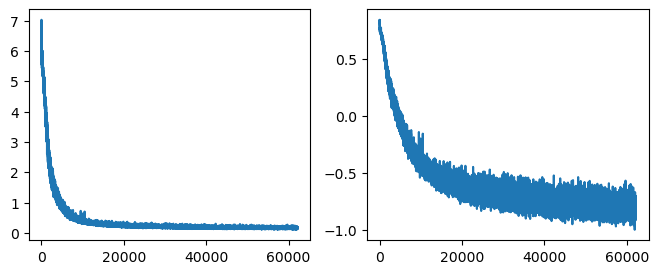

In [48]:
plt.subplots(1, 2, figsize=(8, 3))
plt.subplot(1,2,1); plt.plot(lossi)
lossi10 = [math.log10(i) for i in lossi]
plt.subplot(1,2,2);plt.plot(lossi10)

In [49]:
# Predict
torch.manual_seed(42)
word = "分开"
word2i = [stoi[s] for s in word]
length = 50     # impending words to corresponding length

words = []
H = torch.randn([1, num_hidden], dtype=torch.float32, device=device)
with torch.no_grad():
    for i in range(length):
        inputx = torch.tensor(word2i[i]) if i < len(word2i) else torch.tensor(words[-1])
        X = F.one_hot(inputx, num_classes=vocab_size).view(1, vocab_size)
        X = X.to(dtype=torch.float32, device=device)
        H = torch.tanh(torch.matmul(X, W_xh) + torch.matmul(H, W_hh) + b_h)   # (batch_size, num_hidden) + (batch_size, num_hidden) + (1, num_hidden)
        output = torch.matmul(H, W_hq) + b_q    # (batch_size, vocab_size)   
        probs = F.softmax(output, dim=1)
        y = probs.argmax(dim=1).item()
        if i < len(word2i):
            words.append(word2i[i])
        else:
            words.append(y)

print(''.join(itos[i] for i in words))

分开我 不知不觉 我跟了这节奏 后知后觉 又过了一个秋 后知后觉 我该好好生活 我该好好生活 不知不


In [50]:
print(f'perplexity {math.exp(l.item())}')

perplexity 1.1784402624983772


# nn.RNN

In [ ]:
class RNNModel(nn.Module):  # The default activation function is tanh
    def __init__(self, input_size, hidden_size, num_layers=1):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers)  # there is activation function in nn.RNN
        self.fc = self.fc(hidden_size, input_size)
        

In [52]:
rnn = nn.RNN(vocab_size, 256, 1)
test = torch.randn([35, 32, vocab_size])
print(test.shape)
output, ht = rnn(test)
print(output.shape, ht.shape)

torch.Size([35, 32, 1027])
torch.Size([35, 32, 256]) torch.Size([1, 32, 256])
